In [1]:
import pandas as pd
import random as rd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque  # Add this import

!which python



/Users/berat/Desktop/quantum_entanglement/.venv/bin/python


In [15]:
import pandas as pd
import random as rd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque

class QuantumNetwork:
    def __init__(self, initialEdges, pGen, cutOffAge, maxLinks):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.cutOffAge = cutOffAge
        self.maxLinks = maxLinks
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)

    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def getState(self):
        # Create a dictionary of edge information
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
    
    def generateGlobalEntanglements(self):
        for edge in self.initialEdges:
            if rd.random() < self.pGen:
                self.generateLocalEntanglements(*edge)
    
    def generateLocalEntanglements(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            if len(self.G.edges[edge]['entanglements']) < self.maxLinks:
                self.G.edges[edge]['entanglements'].appendleft(0)
    
    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)

    def increaseGlobalEntanglementAge(self):
        edges_to_remove = []
        for edge in list(self.G.edges()):
            newAges = [age + 1 for age in self.G.edges[edge]['entanglements'] if age < self.cutOffAge]
            self.G.edges[edge]['entanglements'] = deque(newAges)
            if len(self.G.edges[edge]['entanglements']) == 0:
                edges_to_remove.append(edge)
        for edge in edges_to_remove:
            self.G.remove_edge(*edge)

class WaitingNetwork(QuantumNetwork):
    def __init__(self, initialEdges, pGen, cutOffAge, maxLinks, goalStates, weights):
        super().__init__(initialEdges, pGen, cutOffAge, maxLinks)
        self.goalStates = goalStates
        self.weights = weights
        self.total_iterations = 0
        self.success_counts = {str(goal): 0 for goal in goalStates}
    
    def isTerminal(self, desiredStates=None):
        states_to_check = desiredStates if desiredStates is not None else self.goalStates
        
        for start, end in states_to_check:
            if not nx.has_path(self.G, start, end):
                return False
        return True
    
    def getReward(self):
        self.total_iterations += 1
        reward = 0
        
        # Check each goal state
        for i, goal in enumerate(self.goalStates):
            if nx.has_path(self.G, goal[0], goal[1]):
                # Update success count for this goal
                self.success_counts[str(goal)] += 1
                
                # Calculate EDR (success rate) for this goal
                edr = self.success_counts[str(goal)] / self.total_iterations
                
                # Calculate reward component: (p^2 / edr) * weight
                reward_component = (self.pGen ** 2) / max(edr, 1e-10)  # Avoid division by zero
                reward += reward_component * self.weights[i]
        
        return reward

    def drawState(self):
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        pos = nx.spring_layout(G_viz, seed=27)
        
        # Draw initial edges (potential connections) in grey dashed lines
        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        # Draw current entanglements in blue solid lines
        nx.draw_networkx_edges(G_viz, pos=pos,
                            edgelist=self.G.edges(),
                            edge_color='blue',
                            width=2)
        
        # Draw nodes
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        # Add edge labels for number of entanglements
        edge_labels = {edge: len(self.G.edges[edge]['entanglements']) 
                      for edge in self.G.edges()}
        nx.draw_networkx_edge_labels(G_viz, pos=pos, edge_labels=edge_labels)
        plt.show()

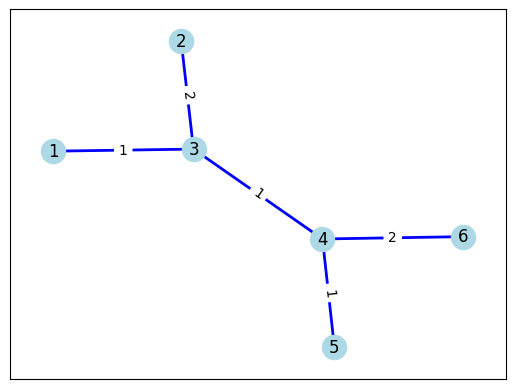

None
Is Terminal: True


0.6400000000000001

In [22]:
initialEdges = [(1,3), (2,3), (3,4), (4,5), (4,6)]
goalStates = [(1, 5), (2, 6)]
pGen = 0.8
cutOffAge = 1
maxLinks = 2
weights = [0.7, 0.3]
rd.seed(27)

network = WaitingNetwork(initialEdges, pGen, cutOffAge, maxLinks, goalStates, weights)
network.getState()
network.generateGlobalEntanglements()
network.generateGlobalEntanglements()
print(network.drawState())
print(f"Is Terminal: {network.isTerminal()}")
network.getState()
network.getReward()
